# How to be a great modeler

Don't look at import if you want to have a fun

In [1]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import numpy as np

from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

## Intermezzo

We used fingerprints, physico-chemical properties and other descriptors, but today we will try MQNs.
What are they? Nothing but counts.

In [2]:
mol = Chem.MolFromSmiles('O=C(OCC(=O)N(CCC)C/C1=C/C=C(/C)C=C1)C2=CC=CC(O)=C2')
MQN = rdMolDescriptors.MQNs_(mol)
print(MQN)

[20, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 25, 12, 2, 0, 6, 6, 0, 7, 9, 5, 1, 1, 0, 0, 5, 5, 3, 0, 8, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0]


#### MQNs

1. c (carbon)
2. f (fluorine) 
3. cl (chlorine) 
4. br (bromine) 
5. i (iodine) 
6. s (sulfur) 
7. p (phosphorous)
8. an (acyclic nitrogen)
9. cn (cyclic nitrogen) 
10. ao (acyclic oxygen) 
11. co (cyclic oxygen) 
12. hac (heavy atoms)[a] 
13. asb (acyclic single bonds) 
14. adb (acyclic double bonds) 
15. atb (acyclic triple bonds) 
16. csb (cyclic single bonds) 
17. cdb (cyclic double bonds) 
18. ctb (cyclic triple bonds) 
19. rbc (rotatable bonds) 
20. hbam (H-bond acceptor sites)
21. hba (H-bond acceptor atoms)
22. hbdm (H-bond donor sites)
23. hbd (H-bond donor atoms)
24. negc (negative charges)[b]
25. posc (positive charges)[b]
26. asv (acyclic single valent nodes)
27. adv (acyclic divalent nodes)
28. atv (acyclic trivalent nodes)
29. aqv (acyclic tetravalent nodes)
30. cdv (cyclic divalent nodes)
31. ctv (cyclic trivalent nodes)
32. cqv (cyclic tetravalent nodes)
33. r3 (3-membered rings)
34. r4 (4-membered rings)
35. r5 (5-membered rings)
36. r6 (6-membered rings)
37. r7 (7-membered rings)
38. r8 (8-membered rings)
39. r9 (9-membered rings)
40. rg10 (>=10-membered rings)
41. afrc (nodes shared by >=2 rings)
42. bfrc (edges shared by >=2 rings)

### End of intermezzo

## Let's prepare drugbank

In [3]:
drugbank = [m for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m]
mqns = [rdMolDescriptors.MQNs_(m) for m in drugbank]

## Ehm, not today as we can't train anything on drugbank
Well, we can maybe but who has measured values (or how to get them and not steal)

But we have activities for some serotonin receptor. (You can guess where did I download them from?)

It is small so we can read them into out precious memory.

In [4]:
data_file = open("../data/serotonin_2a_IC50.csv")
data_file.readline()
def splitter(line):
    spls = line.strip().split("\t")
    return (spls[0],Chem.MolFromSmiles(spls[5]),float(spls[7]))
mols = [splitter(line) for line in data_file]

In [5]:
mqns = [rdMolDescriptors.MQNs_(m[1]) for m in mols]
vals = [m[2] for m in mols]

## We want to predict values so we use some regression model

We start with SVM what is said to be gold standard

In [6]:
clf = svm.SVR()
clf.fit(mqns, vals)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

What is our prediction?

In [7]:
clf.predict(mqns[:1]),vals[0]

(array([28.35163602]), 940.0)

Horrible!!! It can't be right!

Do it for every compound and check if it is just outlier

In [8]:
# Our old good function to display points
def plot(X, *args, highlights=set()):
    fig = plt.figure()
    #ax = plt.subplot(111)
    for i, point in enumerate(X):
        x,y = point
        if i in highlights:
            plt.plot([x],[y],"r.", markersize=4)
        else:
            plt.plot([x],[y],"k.", markersize=1)
    plt.show()

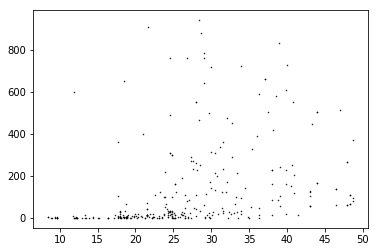

In [9]:
preds = clf.predict(mqns)
plot(zip(preds,vals))

Could it be a wrong model? Random forest is another gold standard.

In [10]:
clf2 = ensemble.RandomForestRegressor()
clf2.fit(mqns, vals)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

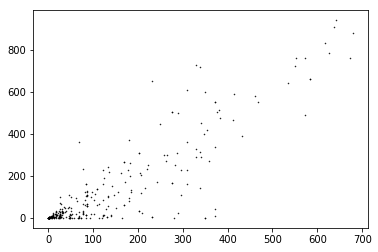

In [11]:
preds2 = clf2.predict(mqns)
plot(zip(preds2,vals))

Well, I feel this is more reasonable, but somewhere over the rainbow, blue birds say to use pIC50 instead of IC50.

In [12]:
s = lambda x : -1.0 * np.log10(x / 1.0e9)
pvals = [s(val) for val in vals]

In [13]:
clf3 = ensemble.RandomForestRegressor()
clf3.fit(mqns, pvals)
preds3 = clf3.predict(mqns)

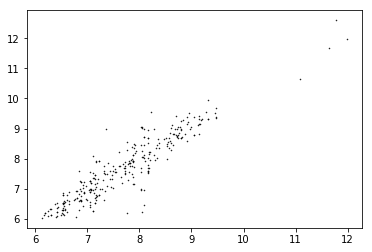

In [14]:
plot(zip(preds3,pvals))

Looks nice, but we need some hard numbers to test if it is really nice.

Hups, we don't have testset.

## So, again and better

In [15]:
# Can't work with generators
trainset, testset = ms.train_test_split(list(zip(mols,mqns,pvals)))
len(trainset), len(testset)

(226, 76)

In [16]:
good_model = ensemble.RandomForestRegressor()
good_model.fit([mqn for m,mqn,val in trainset],[val for m,mqn,val in trainset])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

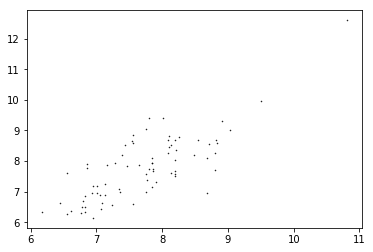

In [17]:
test_predictions = good_model.predict([mqn for m,mqn,val in testset])
plot(zip(test_predictions,[val for m,mqn,val in testset]))

Here are the numbers:

In [18]:
print("R^2: %0.2f" % good_model.score([mqn for m,mqn,val in testset], [val for m,mqn,val in testset]))
print("R: %0.2f" % np.sqrt(good_model.score([mqn for m,mqn,val in testset], [val for m,mqn,val in testset])))
print("MSE: %0.2f" %  mean_squared_error(good_model.predict([mqn for m,mqn,val in testset]), [val for m,mqn,val in testset]))

R^2: 0.61
R: 0.78
MSE: 0.44


This is a life!

Nop, we just have to play more with our data and model(s), e.g. try more descriptors and do some cross-validation to select best parameters for model.

See rdkit.Descriptors.descList

### But even with this bad model, you can predict how active are compounds in drugbank, but don't forget garbage in, garbage out!